In [121]:
import time
tot_tic = time.time()
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
from matplotlib import colormaps
import sys
import pandas as pd
import cantera as ct
import os
from scipy import interpolate
import plotly.graph_objects as go
import numpy as np
import tempfile
from IPython.display import display, clear_output
from adjustText import adjust_text

In [122]:
from math import atan2,degrees
import numpy as np

#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

In [123]:
injectants =        ['H2O', 'PF4acid', 'PF4Sulfonater', 'PF5acid' , 'PF5Sulfonater','PF6acid','PF6Sulfonater','PF7acid','PF7Sulfonater','PF8acid','PF8Sulfonater'] # list of injectants, must be in the mechanism file.

injectant_concs =   [70, 0.000685,   0.0202,         0.00341,    0.0164,         0.0111,     0.118,          0.00316,    0.0136,         0.0123,     0.802] # injected species concentration in furnace @ injection point (ppm)
injectant_units = ['wt%', 'wt%', 'wt%', 'wt%', 'wt%', 'wt%', 'wt%', 'wt%', 'wt%', 'wt%', 'wt%'] # units of injected species concentration in furnace @ injection point (ppm)
ER = 0.834 
injectant_tot_conc=20 # injected species concentration in furnace @ injection point (ppm)
injectant_port = 6 # port number of injectant
firing_rate = 45 # firing rate in kW

In [124]:
#converting concentration to mole fraction
mechanism = 'new_mech_file.yaml' # mechanism file, irrelevant if 'yaml' = False
gas = ct.Solution(mechanism)
orig_concs = [i for i in injectant_concs]
#convert injectant_concs from specified unit to ppm
for i in range(len(injectant_concs)):
    if injectant_units[i] == 'ppb':
        injectant_concs[i] = injectant_concs[i] * 1e3
    elif injectant_units[i] == 'ppm':
        injectant_concs[i] = injectant_concs[i]
    elif injectant_units[i] == 'pph':
        injectant_concs[i] = injectant_concs[i] * 1e-3
    elif injectant_units[i] == 'ng/g':
        injectant_concs[i] = injectant_concs[i] * 1e-3
    elif injectant_units[i] == 'mg/kg':
        injectant_concs[i] = injectant_concs[i]
    elif injectant_units[i] == 'wt%':
        injectant_concs[i] = injectant_concs[i] * 1e4
    else:
        raise ValueError("Unknown unit of concentration.")

#use ratio of injectant_concs to make the sum of the injectant_concs equal to injectant_tot_conc
injectant_concs = [i * injectant_tot_conc / sum(injectant_concs) for i in injectant_concs]

#make dictionary of injectants, concentrations, and units
compounds_info = []
for i in range(len(injectants)):
    compounds_info.append({'name': injectants[i], 'concentration': injectant_concs[i], 'unit': injectant_units[i]})

# Fetch the molar masses from Cantera for the compounds
molar_masses = {species.name: species.molecular_weight for species in gas.species()}

# Calculate moles for each compound based on the unit of concentration
total_moles = 0
for compound in compounds_info:
    compound_name = compound['name']
    if compound_name in molar_masses:
        molar_mass = molar_masses[compound_name]
        if compound['unit'] == 'ppb' or 'ng/g':
            # Convert ppb to g/g, then to moles
            compound['moles'] = (compound['concentration'] * 1e-9) / molar_mass
        elif compound['unit'] == 'ppm' or 'mg/kg':
            # Convert ppm to g/g, then to moles
            compound['moles'] = (compound['concentration'] * 1e-6) / molar_mass
        elif compound['unit'] == 'pph' or 'wt%':
            # Convert weight percent to g/g, then to moles
            compound['moles'] = (compound['concentration'] * 0.01) / molar_mass
        else:
            raise ValueError("Unknown unit of concentration.")
        total_moles += compound['moles']
    else:
        raise ValueError(f"Molar mass for {compound_name} not found in mechanism file.")

# Calculate mole fractions
for compound in compounds_info:
    compound['mole_fraction'] = compound['moles'] / total_moles

#set injection_concs to mole fractions
injectant_concs = []
for compound in compounds_info:
    injectant_concs.append(compound['mole_fraction'])

C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\2038849908.py:3: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in h/RT detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  -491.6887451453692
	Value computed using high-temperature polynomial: -491.36138060736056


C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\2038849908.py:3: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in s/R detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  143.6694692884878
	Value computed using high-temperature polynomial: 143.3968942035545




In [125]:

def strclean(s):
    return str(s).replace(' ', '').replace('[','').replace(']','').replace("'",'')

#script to generate folder name based off specified conditions, using the format specified above.
if len(injectants) > 1:
    pollutant_index = 0
    output_folder = 'Output/AFFF/'+str(pollutant_index)+str(injectant_port)+'.'+str(firing_rate).replace('.','')+'_'+str(firing_rate)+'kW_'+strclean(injectants[:3])+'_port'+str(injectant_port)
else:
    if injectants[0] == 'CF4':
        pollutant_index = 1
    elif injectants[0] == 'CHF3':
        pollutant_index = 2
    elif injectants[0] == 'CHF6':
        pollutant_index = 3
    else:
        pollutant_index = 0
        
    output_folder = 'Output/'+str(pollutant_index)+str(injectant_port)+'.'+str(firing_rate).replace('.','')+'_'+str(firing_rate)+'kW_'+strclean(injectants)+'_port'+str(injectant_port)

    
if os.path.exists(output_folder) == False: #check if output folder exists
    os.makedirs(output_folder) #create output folder if it doesn't exist
    print('Creating new folder: ' + output_folder)
else:
    #open the run_conditions.txt file and check if the same conditions are being used for this run, if so, then continue. If not, make a subfolder in the run folder with the new conditions.
    # Write the current conditions to a temporary file
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        f.write('Injectants: '+ ', '.join(injectants) + '\n')
        f.write('Injectant Concentration (converted to mole fraction): '+ str(injectant_concs) + '\n')
        f.write('Injectant Total Concentration: '+ str(injectant_tot_conc) + '\n')
        f.write('Injectant Port: '+ str(injectant_port) + '\n')
        f.write('firing rate: ' + str(firing_rate) + '\n')

    # Read the contents of the temporary file and run_conditions.txt
    with open(f.name, 'r') as file1, open(output_folder+'/run_conditions.txt', 'r') as file2:
        file1_contents = [next(file1) for x in range(5)]
        file2_contents = [next(file2) for x in range(5)]
    print(file1_contents)
    print(file2_contents)
    # Check if the contents are the same
    if file1_contents == file2_contents:
        # rest of your code
        print('Same conditions, continuing with run')
    else:
        print('Different conditions, creating subfolder')
        conditions = '_'.join([strclean(injectants[i])+'-'+str(injectant_concs[i])[:5] for i in range(len(injectants))[:5]])+'_'+str(injectant_tot_conc)+'_'+str(injectant_port)+'_'+str(firing_rate)
        print(conditions)
        output_folder = output_folder+'/'+conditions
        if os.path.exists(output_folder) == False:
            os.makedirs(output_folder) #create output folder if it doesn't exist

file = open(f'{output_folder}/log.txt', 'w') #create log file
file.close() #close log file



In [126]:
########## System conditions ##########
lengths = [36,13,133,97] # inches
diameters = [20.5,15.5,10.5,8] # inches

SR_275 = 2.161
# SR_30 = 
SR_32 = 1.842
SR_34 = 1.737
SR_35 = 1.67
# SR_395 = 
SR_41 = 1.42
SR_43 = 1.357
SR_45 = 1.295

exhaust_275 = 920 + 44.7
exhaust_32 = 912 + 52
exhaust_34 = 910 + 55
exhaust_41 = 898 + 66.6
exhaust_43 = 902 + 69.8
exhaust_45 = 900 + 73

measured_temps_275 = [927,864,819,753,711,655,501,449,399,364] # °C
measured_temps_30 = [931, 906, 850, 803, 763, 712, 526, 477, 430, 391]
#measured_temps_32 = 
#measured_temps_34 =
#measured_temps_35 = 
measured_temps_395 = [1074, 1065, 996, 948, 889, 826, 598, 549, 497, 441]
#measured_temps_41 = 
#measured_temps_43 = 
measured_temps_45 = [1198, 1177, 1116, 1055, 997, 916, 649, 602, 553, 491]

inject_dist_port1 = 6 # inches
inject_dist_port4 = 55 # inches
inject_dist_port6 = 79  # inches
inject_dist_port8 = 103 # inches


firing_rate = output_folder.split('_')[0]
firing_rate = firing_rate.split('.')[1]
if firing_rate == '275':
    SR = SR_275 # stoichiometric ratio
    exhaust_gas_q = exhaust_275 # total volumetric flow rate (L/min)
    measured_temps = measured_temps_275 # °C
    firing_rate = '27.5'
elif firing_rate == '45':
    SR = SR_45
    exhaust_gas_q = exhaust_45
    measured_temps = measured_temps_45

if output_folder.split('_')[3] == 'port1':
    injection_loc = inject_dist_port1 # inches, see files\rainbow_ports.txt for list of port locations
elif output_folder.split('_')[3] == 'port4':
    injection_loc = inject_dist_port4 # inches, see files\rainbow_ports.txt for list of port locations
elif output_folder.split('_')[3] == 'port6':
    injection_loc = inject_dist_port6 # inches, see files\rainbow_ports.txt for list of port locations
elif output_folder.split('_')[3] == 'port8':
    injection_loc = inject_dist_port8


########## Mechanism ##########
#mechanism = 'NCSU_PFASmech1.0.yaml' # mechanism file, irrelevant if 'yaml' = False

yaml = False # if False, below chemkin format files will be converted to a Cantera friendly yaml file
kinetics = 'NCSU_PFASmech1.91_Kinetics.inp'
thermo = 'NCSU_PFASmech1.9_Thermo.dat'
output = 'new_mech_file.yaml' # must have .yaml extension

########## Temperature fitting ##########
measured_temps_locs = [18,55,79,103,127,151,201,225,249,273] # inches
ff = 0.9 # "fudge factor" for flame temp because Cantera's solution is adiabatic
spline = True # fit using scipy.interpolate.UnivariateSpline (True) or numpy.polyfit (False)
k = 3 # spline degree
s = None # spline smoothing factor, see scipy documentation for guidance
pdeg = 4 # polynomial degree, only appliciable if 'spline' is set to False

########## Path diagram ##########
path_res_time = 0.001 # seconds, precision will be limited by grid resolution settings
path_element = 'F' # case sensitive
path_species = 'all' # 'all' or individual species name to only display fluxes connected to that species
path_threshold = 0.0001 # kmol/m3/sec
path_details = False # or True

########## Grid resolution ##########
post_injection_res_time_step = 1e-3 # residence time grid size (seconds)
post_injection_duration = 1e-1 # seconds
elsewhere_res_time_step = 1e-2 # residence time grid size (seconds)

########## Additional settings ##########
run_with_dialog = False # Running with dialog may be best for public distributions
print_info_every = 100 # print simulation info every n time steps
atol = 1e-15 # absolute error tolerance for reactor equations solver
rtol = 1e-9 # relative error tolerance for reactor equations solver
it0 = True # generate output with pre-injection data trimmed off (True) or not trimmed (False)
concentrations_interactive_plot_cutoff = 1e-9 # mol fraction
rates_interactive_plot_cutoff = 1e-9 # mol/m3/s
save_rates_solution = False # Generating the net rates excel spreadsheet adds a lot of wall time
individual_plots = False # Generating individual species concentration plots adds a lot of wall time
major_species_cutoff = 1e-6 # mol fraction
minor_species_cutoff = 1e-15 # mol fraction

#write output folder, firing rate, injection loc, injectant, injection concentration, and mechanism to a single file for reference
with open(output_folder+'/run_conditions.txt', 'w') as f: 
    f.write('Injectants: '+ ', '.join(injectants) + '\n')
    f.write('Injectant Concentration (converted to mole fraction): '+ str(injectant_concs) + '\n')
    f.write('Injectant Total Concentration: '+ str(injectant_tot_conc) + '\n')
    f.write('Injectant Port: '+ str(injectant_port) + '\n')
    f.write('firing rate: ' + firing_rate + '\n')



    f.write('output folder: ' + output_folder + '\n')
    
    f.write('injection location: ' + str(injection_loc) + '\n')
    
    f.write('Injectant Concentrations Input: '+ str(orig_concs) + '\n')
    
    f.write('Mechanism: ' + mechanism + '\n')
    f.write('SR: ' + str(SR) + '\n')
    f.write('ER: ' + str(ER) + '\n')
    f.write('Exhaust Gas Flow Rate: ' + str(exhaust_gas_q) + '\n')
    f.write('Measured Temperatures: ' + str(measured_temps) + '\n')
    f.write('Measured Temperatures Locations: ' + str(measured_temps_locs) + '\n')
    

In [127]:


def myprint(txt): #print to console and log file
    print(txt, file=open(f'{output_folder}/log.txt', 'a'))
    print(txt)
    file.close()
    
def myinput(txt): #input to console and log file
    inp = input(txt)
    print(txt+inp, file=open(f'{output_folder}/log.txt', 'a'))
    file.close()
    return inp

In [128]:
import os
# restart function only works for executable, not in python interpreter
def restart_main():
    executable = sys.executable
    executable_filename = os.path.split(executable)[1]
    os.execv(executable, sys.argv)

while os.system('dot -V') == 1:
    myprint('graphviz must be installed on your PATH to generate reaction pathway diagrams')
    time.sleep(1)
    myinput('press enter to launch graphviz installer')
    
    path_to_file = 'files/'
    exe = 'graphviz-install.exe'
    cur_dir = os.getcwd()
    os.chdir(path_to_file) # change folder
    os.system(f'{exe}')
    os.chdir(cur_dir) # go back
    
    myprint('graphviz installed -> restarting PFRTP run...')
    
    restart_main()

In [129]:
if yaml == False and os.path.exists(output) == True:
    myprint('output mechanism yaml file already exists -> no mechanism file format conversion necessary...')
    mechanism = output
elif yaml == False:
    myprint('converting chemkin mechanism files to yaml file...')
    args = f' python -m cantera.ck2yaml --input={kinetics} --thermo={thermo} --output={output} --permissive'
    os.system(args)
    mechanism = output
else:
    ...

In [130]:
myprint(' ')
gri_names = list(ct.Solution('files/gri3.0.yaml').species_names)
mech_names = list(ct.Solution(mechanism).species_names)
notin = []
for species in gri_names:
    if species in mech_names:
        ...
    else:
        notin.append(species)

if notin:
    myprint('WARNING! PFRTP uses the GRI-Mech 3.0 kinetic mechanism to estimate the composition of flame off-gas given the input stoichiometric ratio. '+
            'The subsequent evolution of that gas in the PFR system is based on the input kinetic mechanism.'+
            ' GRI-Mech 3.0 contains '+str(len(notin))+' species that were not identified in the input mechanism: '+" ".join(notin))
    myprint('You may wish to (a) check if any of the listed species are included in the input mechanism using a different name and rename them accordingly and/or (b) confirm that the listed species are not relevant in this case.')
    myprint('The GRI-Mech 3.0 file used by PFRTP can be found at files')
    myprint(' ')
    myprint(' ')
else:
    ...

C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\348833218.py:3: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in h/RT detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  -491.6887451453692
	Value computed using high-temperature polynomial: -491.36138060736056


C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\348833218.py:3: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in s/R detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  143.6694692884878
	Value computed using high-temperature polynomial: 143.3968942035545




In [131]:
# Burn a flame and save the off-gas state as a yaml file.

fname = 'files/flames/'+'flame_'+str(SR)+'.yaml'
if os.path.exists(fname) == False:
    myprint('flame solution does not exist for input SR -> solving flame...')
    To = 300
    Po = 101325
    gas = ct.Solution('files/gri3.0.yaml')
    gas.set_equivalence_ratio(ER, "CH4", {"O2": 1.0, "N2": 3.76})
    gas.TP = To, Po
    flame = ct.FreeFlame(gas)
    flame.solve(auto=True, loglevel=1)
    flame.gas.write_yaml(fname)
    myprint('flame solved -> creating polynomial fit for temperature profile...')
else:
    myprint('flame solution exists for input SR -> fitting temperature profile...')

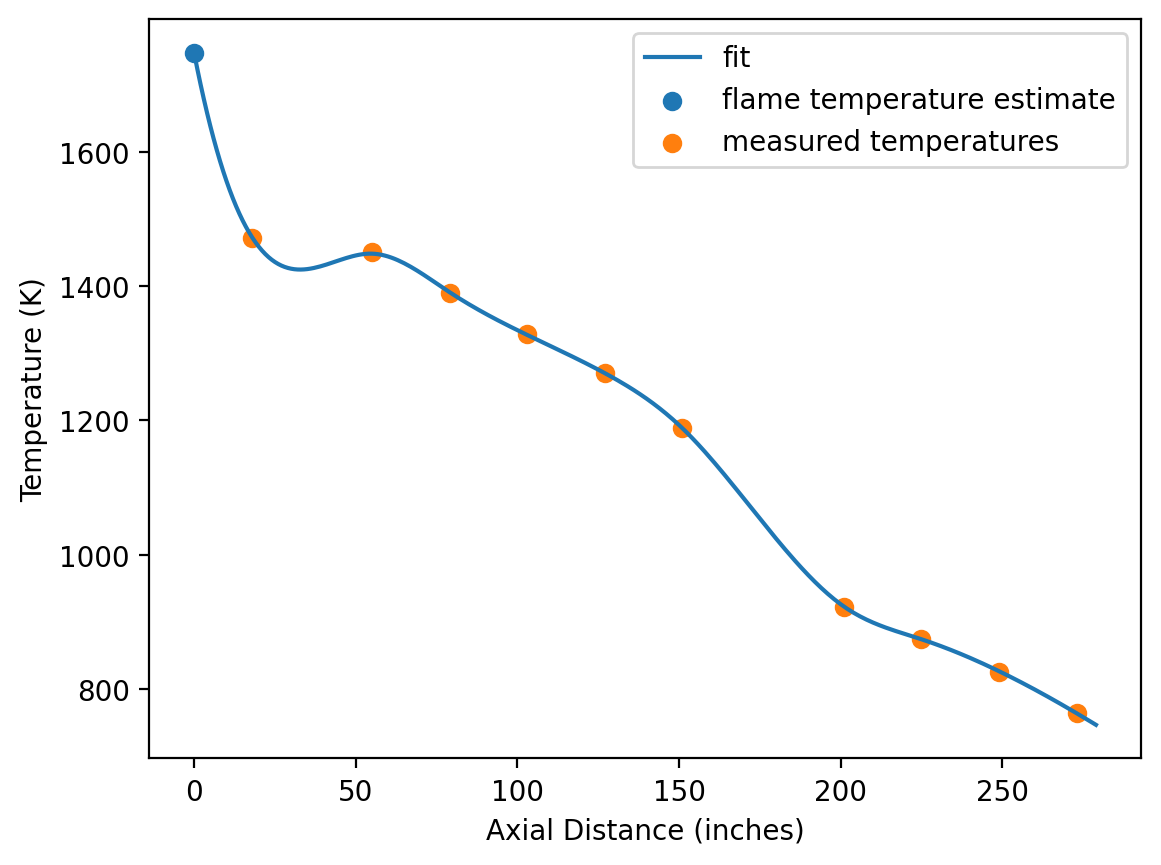

In [132]:
# Convert user input to model-friendly input

flame_temp_estimate = ct.Solution(fname).T*ff

if 0 in measured_temps_locs:
    measured_temps_new = [x+273.15 for x in measured_temps]
    measured_temps_locs_new = measured_temps_locs
else:
    measured_temps_new = [flame_temp_estimate]+[x+273.15 for x in measured_temps]
    measured_temps_locs_new = [0] + measured_temps_locs

# fit temps to axial length (a reasonable simplification)
xf = range(sum(lengths)+1)
if spline == True:
    spl = interpolate.UnivariateSpline(measured_temps_locs_new, measured_temps_new, k=k, s=s)
    T_fit = spl(xf)
else:
    z = np.polyfit(measured_temps_locs_new, measured_temps_new, pdeg)
    f = np.poly1d(z)
    T_fit = np.round(f(xf), 0) #### don't need round anymore?

# Plot fit
plt.plot(xf,T_fit,label='fit')
if 0 in measured_temps_locs:
    plt.scatter(measured_temps_locs,measured_temps_new,label='measured')
else:
    plt.scatter(0,flame_temp_estimate,label='flame temperature estimate')
    plt.scatter(measured_temps_locs,measured_temps_new[1:],label='measured temperatures')
plt.ylabel('Temperature (K)')
plt.xlabel('Axial Distance (inches)')
plt.legend()
plt.savefig(output_folder+'\\temperature_fit_axial_distance.png',dpi=300,
                    bbox_inches='tight',facecolor='white')
plt.show()

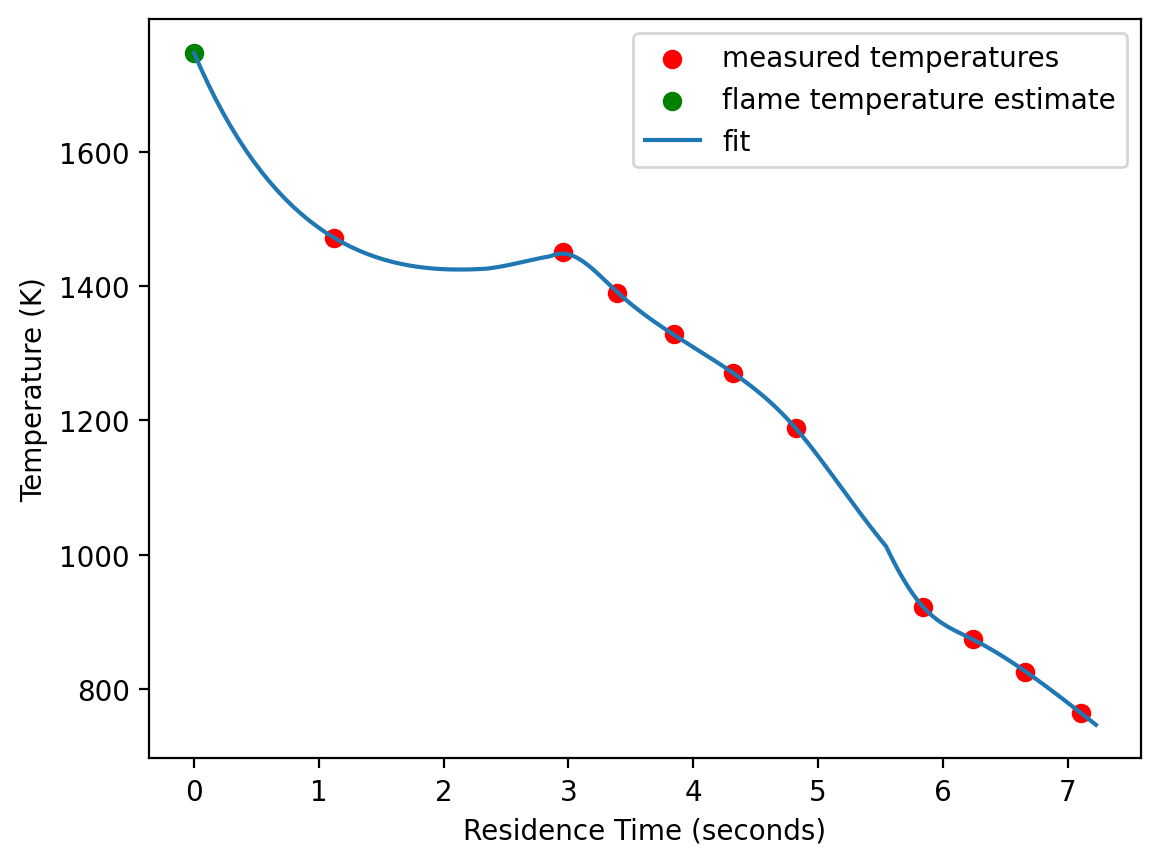

In [133]:
# Convert axial length fit to residence time fit based on slice volumes, temperatures, and flow rates

# start by making list of slice volumes, slices have 1-inch lengths
v = [0]
for l,d in zip(lengths,diameters):
    slice_lengths = np.zeros(l) + 1 # a list of "1"s the length of the nth section
    slice_vols = slice_lengths * np.pi * d**2 / 4 # a list of the corresponding volumes
    v.extend(list(slice_vols)) # extend the total list of volumes
    
Q = exhaust_gas_q * T_fit / 293.15 # list of T-corrected flows through each volume (L/min) based on ideal gas law
res_t = 60*np.array(v)/(61*Q) # list of slice res times (seconds), divided by 61 to convert L/min to in^3/min
t_cum = np.cumsum(res_t) # a list of slice cumulative res times (seconds)

# Plot fit
if 0 in measured_temps_locs:
    plt.scatter(t_cum[np.round(measured_temps_locs,0)],measured_temps_new,c='red',label='measured')
else:
    plt.scatter(t_cum[np.round(measured_temps_locs,0)],measured_temps_new[1:],c='red',label='measured temperatures')
    plt.scatter(t_cum[0],measured_temps_new[0],c="green",label='flame temperature estimate')
plt.plot(t_cum,T_fit,label='fit')
plt.ylabel('Temperature (K)')
plt.xlabel('Residence Time (seconds)')
plt.legend()
plt.savefig(output_folder+'\\temperature_fit_res_time.png',dpi=300,
                    bbox_inches='tight',facecolor='white')
plt.show();

In [134]:
myprint('plots of temperature profile fit saved to output folder')
if run_with_dialog == True:
    time.sleep(2)
    myinput('if satisfied with fit, press enter to run PFR simulation')
else:
    ...
myprint('PFR simulation running...')

In [135]:
# Interpolate res time fit to user-defined resolution
i_t = t_cum[np.round(injection_loc,0)] #res time at injection location

tgap1 = np.zeros(int(i_t/elsewhere_res_time_step)) + elsewhere_res_time_step # time steps before injection

tinj = np.zeros(int(post_injection_duration/post_injection_res_time_step)) + post_injection_res_time_step # time steps during injection

tgap2 = np.zeros(int((t_cum[-1]-i_t-post_injection_duration)/elsewhere_res_time_step)) + elsewhere_res_time_step # time steps after injection
 
tnew = np.concatenate(([0],tgap1,[i_t-sum(tgap1)],tinj,tgap2)) # list of res times (seconds) at user-defined resolution
f = interpolate.interp1d(t_cum, T_fit)  # interpolate temperature fit to res time fit, using t_cum as x and T_fit as y
Tnew = f(np.cumsum(tnew))

In [136]:
# define a function to map gri flame-gas species concentrations to mechanism species concentrations

def gri_to_mech(mech):
    gri_species = list(ct.Solution('files/gri3.0.yaml').species_names)
    mech_species = list(ct.Solution(mechanism).species_names)
    gri_c = list(ct.Solution(fname).X)
    mech_c = list(ct.Solution(mechanism).X)
    for species in gri_species:
        if species in mech_species:
            mech_c[mech_species.index(species)] = gri_c[gri_species.index(species)]
        else:
            ...
    return mech_c

In [137]:
# define the simulation loop for the res time vs. temp profile

def sim(T,t):
    intic = time.time()
    gas1,r1,sim1 = None,None,None
    pressure = ct.one_atm  # constant pressure [Pa]
    gas1 = ct.Solution(mechanism)
    concentrations = gri_to_mech(mechanism)
    rates = list(gas1.net_rates_of_progress)

    # determine index of injectant
    injectant_indices = [ct.Solution(mechanism).species_index(injectant) for injectant in injectants]

    c=[]
    nrp=[]
    flag = False
    timestep = 0
    loop_t_cum = 0
    inj_i = len(tgap1)+2

    for T_i, t_i in zip(T,t):
        
        if timestep >= inj_i and flag == False:
            for i, conc in enumerate(injectant_concs):
                concentrations[injectant_indices[i]] = conc
            flag = True
        else:
            ...

        # wait to append concentrations until time of injection if it0 == True
        if it0 == False or flag == True:
            c.append(concentrations)
            nrp.append(rates)
        else:
            ...

        gas1.TPX = T_i, pressure, concentrations
        r1 = ct.IdealGasConstPressureReactor(gas1,energy="off")
        sim1 = ct.ReactorNet([r1])
        sim1.atol = atol
        sim1.rtol = rtol
        sim1.advance(t_i)
        concentrations = list(r1.thermo.X)
        rates = list(r1.thermo.net_rates_of_progress)

        timestep+=1
        loop_t_cum += t_i
        if (timestep % print_info_every == 0):
            intoc = time.time()
            myprint(
                f'timestep: {timestep}   total residence time (s): {str(round(loop_t_cum, 4))}   temperature (K): {str(round(T_i, 2))}   elapsed wall time(s): {str(round(intoc - intic, 2))}'
            )

    return c, nrp

In [138]:
# run the simulation
tic = time.time()
sim_data, nrp = sim(Tnew,tnew)
toc = time.time()
myprint(
    f'PFR simulation completed with wall time of: {str(round(toc - tic, 2))} seconds'
)

C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\4274655271.py:7: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in h/RT detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  -491.6887451453692
	Value computed using high-temperature polynomial: -491.36138060736056


C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\4274655271.py:7: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in s/R detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  143.6694692884878
	Value computed using high-temperature polynomial: 143.3968942035545


C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\3582896725.py:5: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in h/RT detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  -491.6887451453692
	Value computed using high-temperature polynomial: -491.36138060736056


C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\3582896

In [139]:
# generate excel files
myprint(' ')
if run_with_dialog == True:
    time.sleep(2)
    myinput('press enter to generate output')
else:
    ...
myprint('generating and saving output to output folder...')

In [140]:
cantera_species = ct.Solution(mechanism).species_names
tplot = np.concatenate(([0],np.cumsum(tinj),np.cumsum(tgap2)+sum(tinj)))[:-1]
Tplot = Tnew[len(tnew)-len(sim_data):]

sim_data_new = list(np.array(sim_data).T)
sim_data_new.insert(0,Tplot)
sim_data_new.insert(0,tplot)
sol = np.array(sim_data_new).T
columns = ['Residence Time (seconds)','Temperature (K)'] + cantera_species
pd.DataFrame(sol,columns=columns).to_excel(output_folder+"\\solution_concentrations.xlsx")

C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\2755376790.py:1: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in h/RT detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  -491.6887451453692
	Value computed using high-temperature polynomial: -491.36138060736056


C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\2755376790.py:1: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in s/R detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  143.6694692884878
	Value computed using high-temperature polynomial: 143.3968942035545




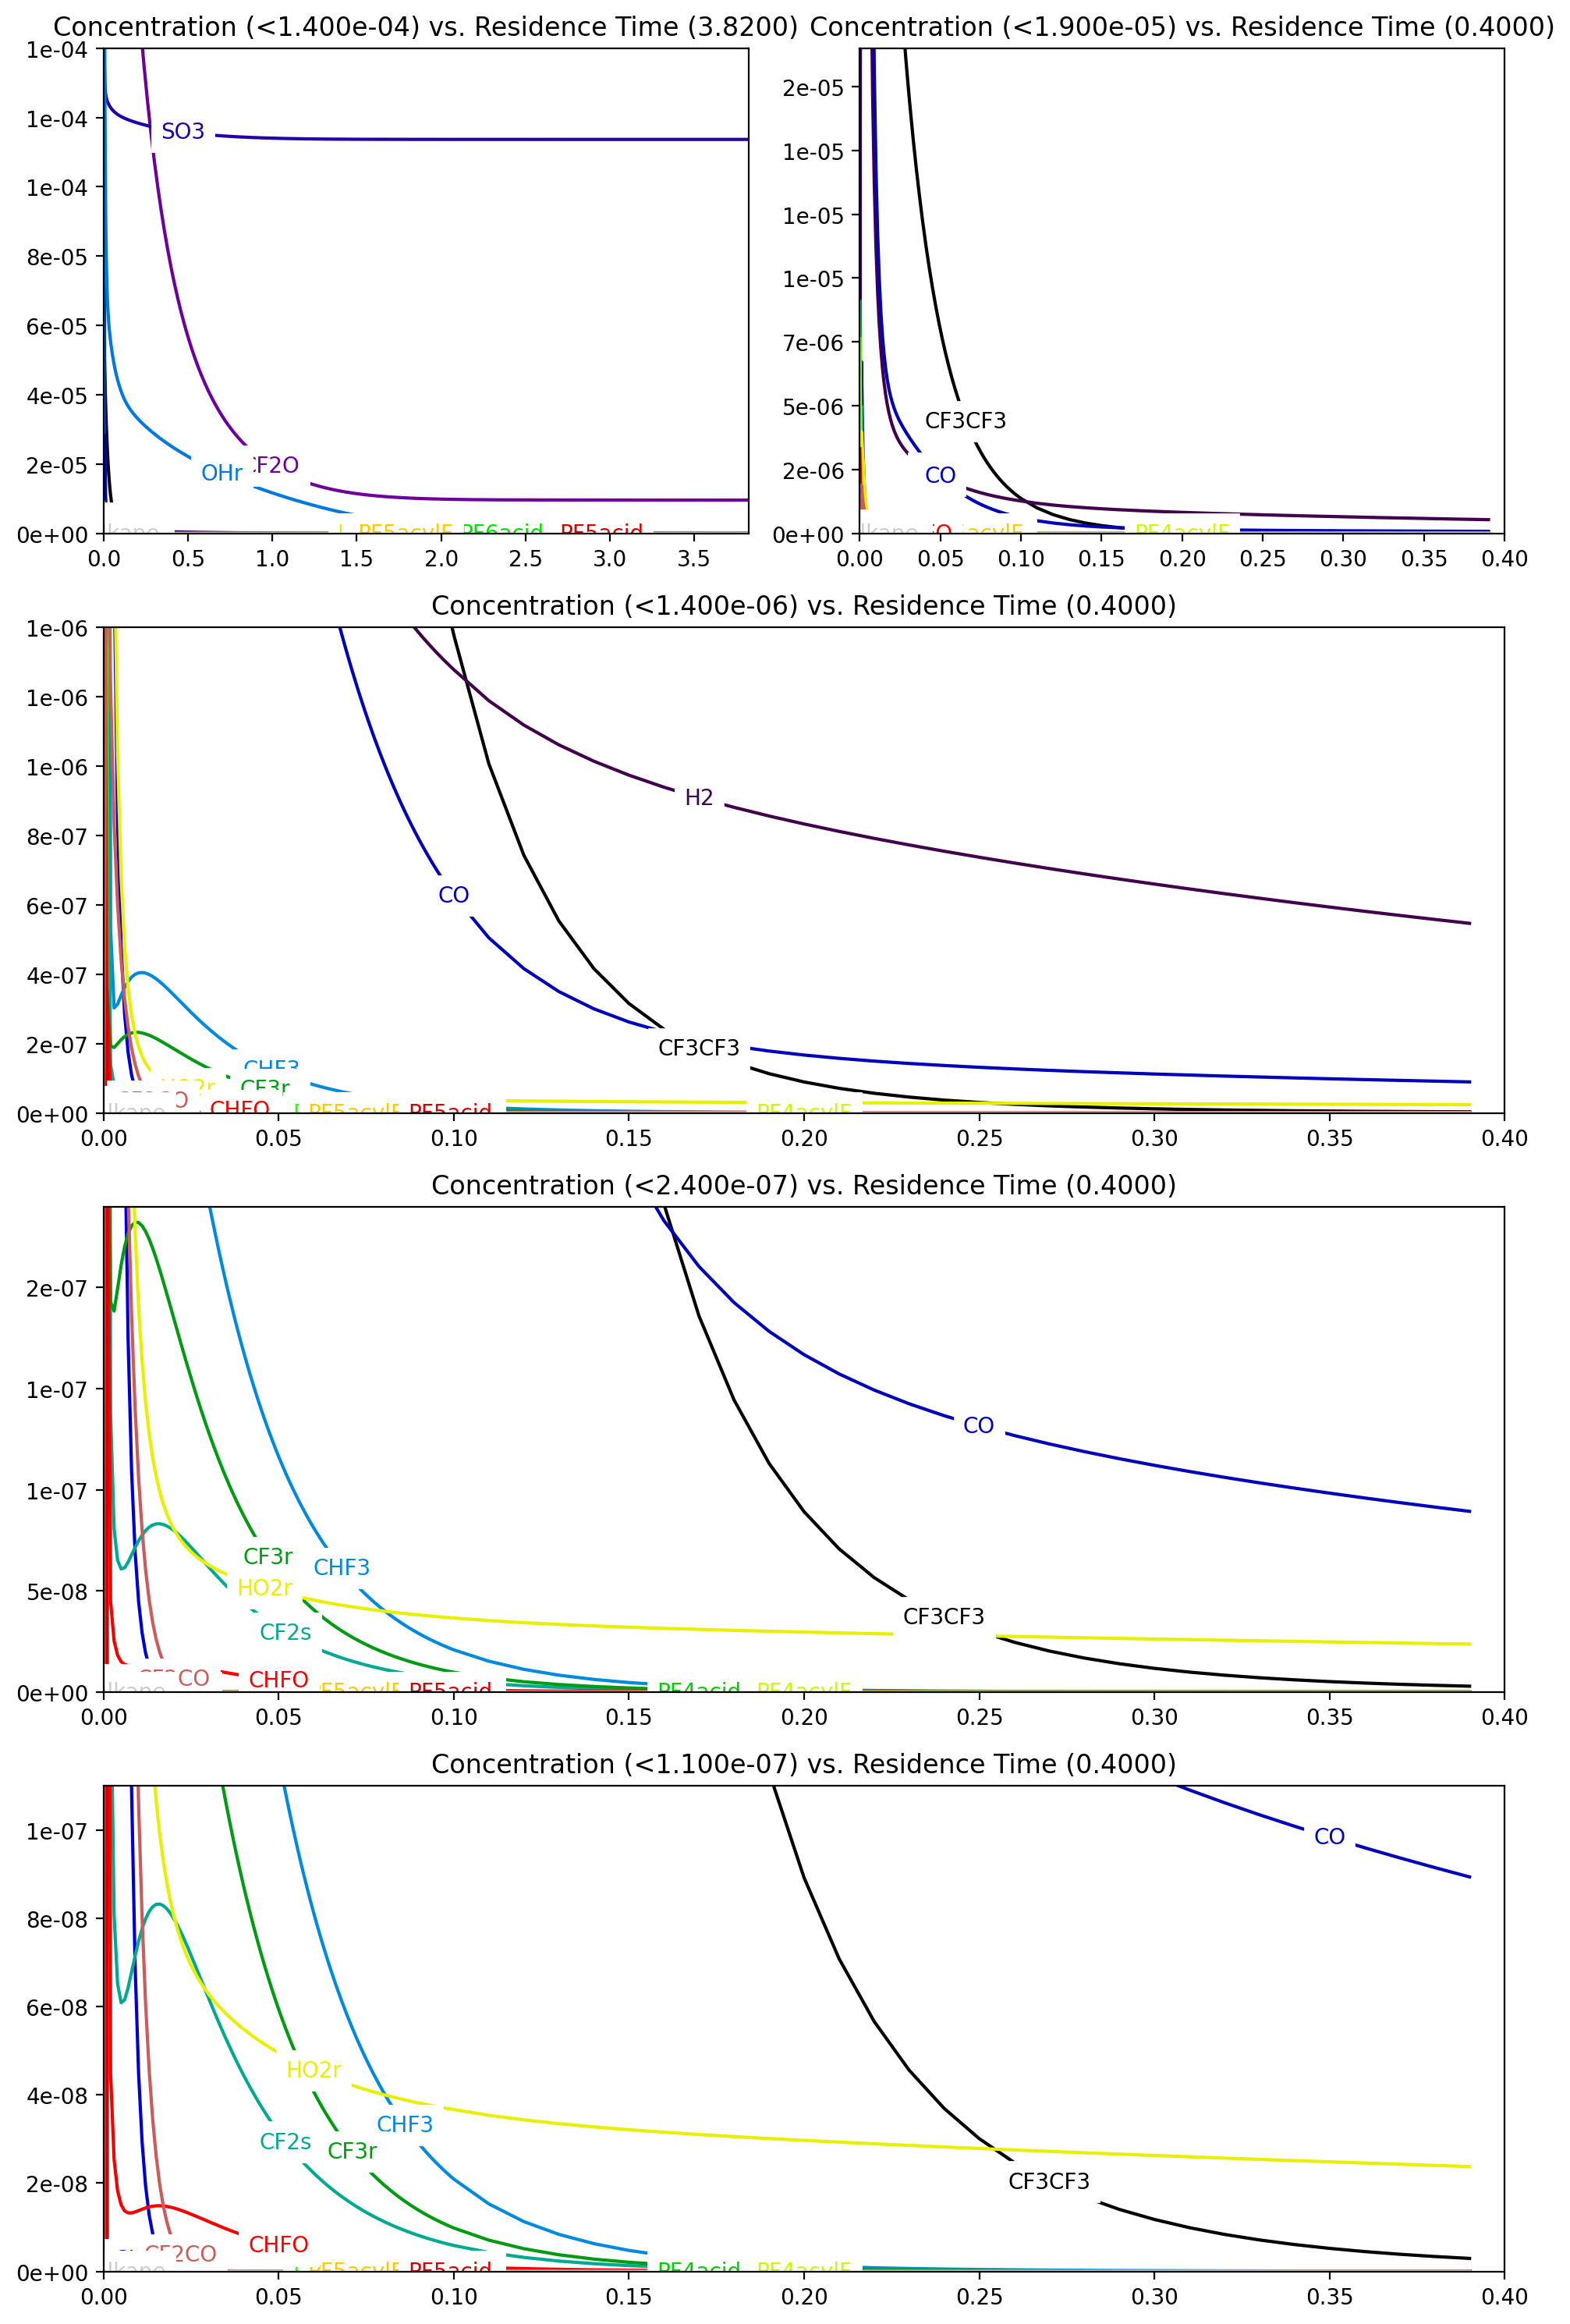

In [141]:
species_to_plot = [
    cantera_species[cantera_species.index('CF3CF3')],
    cantera_species[cantera_species.index('H2')],
    cantera_species[cantera_species.index('HF')],
    cantera_species[cantera_species.index('PF8Sacid')],
    cantera_species[cantera_species.index('CF2O')],
    cantera_species[cantera_species.index('SO3')],
    cantera_species[cantera_species.index('CO')],
    cantera_species[cantera_species.index('CHF2CF3')],
    cantera_species[cantera_species.index('SO2')],
    cantera_species[cantera_species.index('OHr')],
    cantera_species[cantera_species.index('CHF3')],
    cantera_species[cantera_species.index('PF8acylF')],
    cantera_species[cantera_species.index('PF6Sacid')],
    cantera_species[cantera_species.index('rCF2CFO')],
    cantera_species[cantera_species.index('CF2s')],
    cantera_species[cantera_species.index('PF4Sacid')],
    cantera_species[cantera_species.index('CF3r')],
    cantera_species[cantera_species.index('PF5Sacid')],
    cantera_species[cantera_species.index('PF6acylF')],
    cantera_species[cantera_species.index('PF4acid')],
    cantera_species[cantera_species.index('PF6acid')],
    cantera_species[cantera_species.index('PF7acid')],
    cantera_species[cantera_species.index('PF7Sacid')],
    cantera_species[cantera_species.index('PF8acid')],
    cantera_species[cantera_species.index('PF4acylF')],
    cantera_species[cantera_species.index('HO2r')],
    cantera_species[cantera_species.index('PF7acylF')],
    cantera_species[cantera_species.index('PF5acylF')],
    cantera_species[cantera_species.index('CF3CHO')],
    cantera_species[cantera_species.index('PF3acylF')],
    cantera_species[cantera_species.index('PF2alkylr')],
    cantera_species[cantera_species.index('CHFO')],
    cantera_species[cantera_species.index('rCF2COOH')],
    cantera_species[cantera_species.index('PF5acid')],
    cantera_species[cantera_species.index('CH2FCF3')],
    cantera_species[cantera_species.index('CF2CO')],
    cantera_species[cantera_species.index('PF3alkane')],

    ]

import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

def create_subplots():
    # Define a color map
    cmap = colormaps['nipy_spectral'] # Replace 'viridis' with the name of the color map you want to use

    # Generate colors from the color map
    colors = [cmap(i) for i in np.linspace(0, 1, len(species_to_plot))]

    # Define the limits for each subplot
    limits = [
        ([0, max(tplot)], [0, 1.4e-4]),
        ([0, 0.4], [0, 1.9e-5]),
        ([0, 0.4], [0, 1.4e-6]),
        ([0, 0.4], [0, 2.4e-7]),
        ([0, 0.4], [0, 1.1e-7])
    ]

    fig = plt.figure(figsize=(10, 15))  # Increase figure size

    gs = gridspec.GridSpec(4, 2)

    for i, (xlim, ylim) in enumerate(limits):
        if i < 2:
            ax = plt.subplot(gs[0, i])
        else:
            ax = plt.subplot(gs[i-1, :])
        lines = []  # List to store the lines for labeling
        xvals = []  # List to store the x-values for the labels
        for j, spec in enumerate(species_to_plot):
            mask = (tplot >= xlim[0]) & (tplot <= xlim[1])
            concentrations = sol[mask, columns.index(spec)]
            line, = ax.plot(tplot[mask], concentrations, label=spec, color=colors[j])  # Store the line object
            lines.append(line)
            xvals.append(max(tplot[mask]))  # Store the maximum x-value
        ax.set_title('Concentration (<{:.3e}) vs. Residence Time ({:.4f})'.format(ylim[1], xlim[1]))
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
        selected_lines = []
        for line in lines:
            concentrations = line.get_ydata()
            # If a species has a concentration that is within the plot window, then add it to selected_lines
            if (concentrations <= ylim[1]).mean() > 0.05 and (concentrations >= ylim[0]).mean() > 0.05:
                selected_lines.append(line)
            # # Define a threshold for the rate of change
            # threshold = ylim[1] * 1e3  # Adjust this value as needed

            # # Calculate the rate of change
            # rate_of_change = np.max(concentrations) - np.min(concentrations)

            # # If the rate of change is above the threshold
            # if rate_of_change > threshold:
            #     # Add the line to selected_lines
            #     selected_lines.append(line)

        # Remove duplicate values from selected_lines
        selected_lines = list(dict.fromkeys(selected_lines))

        xvals = []
        ymin, ymax = plt.ylim()
        for line in selected_lines:
            xdata = line.get_xdata()
            ydata = line.get_ydata()
            ydata_visible = ydata[(ydata >= ymin) & (ydata <= ymax)]
            if ydata_visible.size > 0:
                ymid = np.mean(ydata_visible)
                closest_index = np.abs(ydata - ymid).argmin()
                xval = xdata[closest_index]
                xvals.append(xval)

        labelLines(selected_lines, align=False, xvals=xvals)  # Label the lines at their maximum x-values

    plt.tight_layout()
    plt.show()
create_subplots()

In [142]:
#spent way too much time making an interactive plot, but it's pretty cool
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
# Button to add the currently selected species to the plot
add_button = widgets.Button(description="Add selected species to plot", icon='plus',style = {'description_width': 'initial'},layout=widgets.Layout(width='auto'))

# List to store the species to plot


# Define the species select widget
species_select = widgets.SelectMultiple(
    options=cantera_species,
    value=[
        cantera_species[cantera_species.index('CF3CF3')]
        ],
    rows=10,
    description='Species',
    disabled=False
)

# Function to filter the species based on the search box
def filter_species(change):
    search_input = change['new']
    if search_input == '':
        # If the search box is empty, display all species
        species_select.options = cantera_species
    else:
        # If the search box is not empty, display only the species that contain the search input
        species_select.options = [spec for spec in cantera_species if search_input.lower() in spec.lower()]


# Function to add the currently selected species to the plot
def add_species(b):
    global species_to_plot
    for spec in species_select.value:
        if spec not in species_to_plot:
            species_to_plot.append(spec)
    update_plot()

# Function to remove the currently selected species from the plot
def remove_species(b):
    global species_to_plot
    for spec in species_select.value:
        if spec in species_to_plot:
            species_to_plot.remove(spec)
    update_plot()

# Function to update the plot scale
def update_plot_scale(change):
    if change['new'] == 'Normal':
        plt.yscale('linear')
    else:
        plt.yscale('log')

# Define the widgets
search_box = widgets.Text(
    value='',
    placeholder='Search species',
    description='Search:',
    disabled=False
)

remove_button = widgets.Button(
    description='Remove selected species from plot',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to remove selected species from plot',
    icon='minus', # (FontAwesome names without the `fa-` prefix)
    style = {'description_width': 'initial'},
    layout=widgets.Layout(width='auto')
)

xlim_slider = widgets.FloatRangeSlider(
    value=[0, 0.4],
    min=0,
    max=tplot[-1],
    step=0.1,
    description='Residence time range:',
    layout=widgets.Layout(width='500px'),
    style = {'description_width': 'initial'}  # Set the width of the slider
)

ylim_slider = widgets.FloatLogSlider(
    value=1.1e-7,
    base=10,
    min=-25,  # max exponent of base
    max=1,  # min exponent of base
    step=0.01,  # exponent step
    description='Concentration range:',
    layout=widgets.Layout(width='500px'),
    style = {'description_width': 'initial'}
)

plot_scale_radio = widgets.RadioButtons(
    options=['Normal', 'Logarithmic'],
    description='Plot scale:',
    disabled=False
)

plot_output = widgets.Output()
def update_ylim_slider_max():
    max_concentration = 0
    for spec in species_to_plot:
        concentrations = sol[:, columns.index(spec)]
        max_concentration = max(max_concentration, np.max(concentrations))
    ylim_slider.max = max_concentration if float(max_concentration) > 0 else 0


def update_plot(change=None):
    with plot_output:

        clear_output(wait=True)  # Clear the current output
        plt.clf()  # Clear the current figure
        # Define a color map
        cmap = colormaps['nipy_spectral'] # Replace 'viridis' with the name of the color map you want to use

        # Generate colors from the color map
        colors = [cmap(i) for i in np.linspace(0, 1, len(species_to_plot))]
        for i, spec in enumerate(species_to_plot):
            mask = (tplot >= xlim_slider.value[0]) & (tplot <= xlim_slider.value[1])
            concentrations = sol[mask, columns.index(spec)]
            # Use the colors in the plot
            plt.title('Concentration (<{}) vs. Residence Time ({})'.format(ylim_slider.value, xlim_slider.value))
            plt.xlim([xlim_slider.value[0], xlim_slider.value[1]])
            plt.ylim([0, ylim_slider.value])
            plt.plot(tplot[mask], concentrations, label=spec, color=colors[i])
            

        lines = plt.gca().get_lines()
        concentrations = []
        for line in lines:
            concentrations.append(np.mean(line.get_ydata()))
        concentrations = np.array(concentrations)
        concentrations = np.abs(concentrations - max(concentrations)/2)
        selected_lines = []
   
        for i, spec in enumerate(species_to_plot):
            mask = (tplot >= xlim_slider.value[0]) & (tplot <= xlim_slider.value[1])
            concentrations = sol[mask, columns.index(spec)]

            #if a species has a concentration that is within the plot window, then add it to selected_lines
            if (concentrations <= ylim_slider.value).mean() >0.05 and (concentrations >= ylim_slider.value * 0.1).mean() >0.05:
                selected_lines.append(lines[i])
            # Define a threshold for the rate of change
            threshold = ylim_slider.value*1e3  # Adjust this value as needed

            # For each line
            for line in lines:
                # Get the y-data (concentration values)
                ydata = line.get_ydata()
                
                # Calculate the rate of change
                rate_of_change = np.max(ydata) - np.min(ydata)
                
                # If the rate of change is above the threshold
                if rate_of_change > threshold:
                    # Add the line to selected_lines
                    selected_lines.append(line)   

        #remove duplicate values from selected_lines
        selected_lines = list(dict.fromkeys(selected_lines))

        xvals = []
        ymin, ymax = plt.ylim()
        for line in selected_lines:
            xdata = line.get_xdata()
            ydata = line.get_ydata()
            ydata_visible = ydata[(ydata >= ymin) & (ydata <= ymax)]
            ymid = np.mean(ydata_visible)
            closest_index = np.abs(ydata - ymid).argmin()
            xval = xdata[closest_index]
            xvals.append(xval)

        # Apply labelLines to the lines with the specified x-values
        labelLines(selected_lines, xvals=xvals, align=True)
        plt.xlabel('Residence Time (seconds)')
        plt.ylabel('Concentration (mol/m^3)')
        plt.xlim(xlim_slider.value)
        plt.ylim([min(concentrations), ylim_slider.value])  # Set the lower limit of the y-axis to 0
        plt.title('Concentration (<{:.3e}) vs. Residence Time ({} s)'.format(ylim_slider.value, xlim_slider.value[1]))
        plt.show()

        # Update the maximum of the ylim slider
        update_ylim_slider_max()

specbox = widgets.VBox([species_select, search_box])
buttonwrap = widgets.VBox([remove_button, add_button], layout=widgets.Layout(justify_content='center'))
specboxwrap = widgets.HBox([specbox, buttonwrap])
topbox= widgets.HBox([plot_scale_radio])
bottombox = widgets.VBox([xlim_slider, ylim_slider])  
slidebuttonbox = widgets.VBox([topbox, bottombox])
graphbox = widgets.HBox([plot_output, slidebuttonbox])
# Call the function to update the ylim_slider maximum value

update_ylim_slider_max()

# Link the widgets to the functions
add_button.on_click(add_species)
remove_button.on_click(remove_species)
search_box.observe(filter_species, names='value')
xlim_slider.observe(update_plot, names='value')
ylim_slider.observe(update_plot, names='value')
plot_scale_radio.observe(update_plot_scale, names='value')

# Display the widgets
display(specboxwrap,graphbox)

# Create the initial plot
with plot_output:
    update_plot()

In [143]:
eff_c = [] # effluent concentrations

for species in np.arange(len(cantera_species)):
    name = cantera_species[species]
    eff_c.append([name, np.array(sim_data)[:,species][-1]])

c = np.array(eff_c)
c_sorted = c[(c[:,1]).astype(float).argsort()[::-1]]
df = pd.DataFrame(c_sorted, columns=['Species','Effluent Concentration (mol fraction)'])
df.to_excel(output_folder+"\\solution_effluent_concentrations.xlsx")

In [144]:
cantera_reactions = list(ct.Solution(mechanism).reaction_equations())
if save_rates_solution == False:
    ...
else:
    nrp_new = list(np.array(nrp).T)
    nrp_new.insert(0,Tnew[len(tnew)-len(nrp):])
    nrp_new.insert(0,tplot)
    sol = np.array(nrp_new).T
    columns = ['Residence Time (seconds)','Temperature (K)'] + cantera_reactions
    pd.DataFrame(sol,columns=columns).to_excel(output_folder+"\\solution_reactions.xlsx")

C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\1582644965.py:1: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in h/RT detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  -491.6887451453692
	Value computed using high-temperature polynomial: -491.36138060736056


C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\1582644965.py:1: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in s/R detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  143.6694692884878
	Value computed using high-temperature polynomial: 143.3968942035545




In [145]:
data = np.array(sim_data).T
fig = go.Figure()
for i in np.arange(len(cantera_species)):
    if max(data[i])<concentrations_interactive_plot_cutoff:
        ...
    else:
        fig.add_trace(go.Scatter(x=tplot,y=data[i],name=cantera_species[i]))
fig.update_yaxes(title_text='Concentration (mol fraction)',type='log',exponentformat='power')
fig.update_xaxes(title_text='Residence Time (seconds)')
fig.update_layout(template='plotly_white')
fig.write_html(output_folder+"\\interactive_plot_concentrations.html")

In [146]:
data = np.array(nrp).T
fig = go.Figure()
for i in np.arange(len(cantera_reactions)):
    if max(data[i])<rates_interactive_plot_cutoff:
        ...
    else:
        fig.add_trace(go.Scatter(x=tplot,y=data[i],name=cantera_reactions[i]))
    
ylabel='Net Rate of Progress (kmol/m3/s)'
fig.update_yaxes(title_text=ylabel,type='log',exponentformat='power')
fig.update_xaxes(title_text='Residence Time (seconds)')
fig.update_layout(template='plotly_white')
fig.write_html(output_folder+"\\interactive_plot_net_rates.html")

In [147]:
# generate figures and excel files
# organize them based on maximum concentration across all slices

if individual_plots == True:
    if os.path.exists(output_folder+r"\\individual_major_species") == False:
        os.makedirs(output_folder+r"\\individual_major_species")
    if os.path.exists(output_folder+r"\\individual_minor_species") == False:
        os.makedirs(output_folder+r"\\individual_minor_species")
    neg_species = [] # negligible species
    eff_c = [] # effluent concentrations

    for species in np.arange(len(cantera_species)):
        name = cantera_species[species]
        eff_c.append([name, np.array(sim_data)[:,species][-1]])

        plt.plot(tplot,np.array(sim_data)[:,species])
        plt.xlabel('Residence time (seconds)')
        plt.ylabel('Concentration (mol fraction)')
        plt.title(name, fontsize=20,fontweight='bold')
        plt.yscale('log')
        if np.max(np.array(sim_data)[:,species]) > major_species_cutoff:
            plt.savefig(output_folder+'\\individual_major_species\\'+name+'.png',dpi=300,
                        bbox_inches='tight',facecolor='white');
        elif np.max(np.array(sim_data)[:,species]) > minor_species_cutoff:
            plt.savefig(output_folder+'\\individual_minor_species\\'+name+'.png',dpi=300,
                        bbox_inches='tight',facecolor='white');
        else:
            neg_species.append([name, np.max(np.array(sim_data)[:,species])])
        plt.close();

    df = pd.DataFrame(neg_species, columns=['Species', 'Maximum Concentration (mol fraction)'])
    df.to_excel(output_folder+"\\negligible_species.xlsx")
    
else:
    ...

C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\793691784.py:2: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in h/RT detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  -491.6887451453692
	Value computed using high-temperature polynomial: -491.36138060736056


C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\793691784.py:2: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in s/R detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  143.6694692884878
	Value computed using high-temperature polynomial: 143.3968942035545




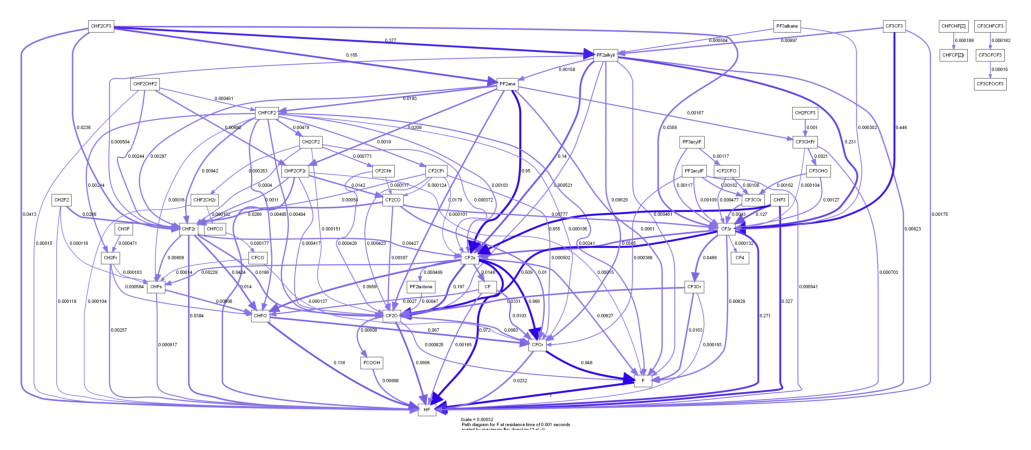

In [148]:
plt.rcParams["figure.dpi"] = 200
gas = ct.Solution(mechanism)
retry = 'y'

while retry == 'y':
    plot_step = np.abs(tplot - path_res_time).argmin()
    P = ct.one_atm
    T = Tplot[plot_step]
    X = sim_data[plot_step]
    gas.TPX = T, P, X

    diagram = ct.ReactionPathDiagram(gas, path_element)
    diagram.threshold = .0001
    diagram.dot_options='node[shape="box"]'
    title = (
        (
            f'Path diagram for {path_element} at residence time of {str(path_res_time)}'
            + ' seconds \r scaled by maximum flux (kmol m-^3 s^-1) \r'
        )
        + ' with displayed threshold of '
    ) + str(path_threshold)
    diagram.title = title
    diagram.show_details = path_details
    log_file = f"{output_folder}/reaction_paths.log"
    with open(log_file, 'w') as f:
        sys.stdout = f
        diagram.build(verbose=True)
        sys.stdout = sys.__stdout__
    # diagram.display_only(-1 if path_species == 'all' else gas.species_index(path_species))
    dot_file = f"{output_folder}/dotfile.dot"
    png_file = f"{output_folder}/reaction_paths.png"
    diagram.write_dot(dot_file)
    os.system(f'dot {dot_file} -Tpng -o {png_file} -Gdpi=100')
    img = mpimage.imread(png_file)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    if run_with_dialog == True:
        retry = myinput('path diagram saved to output folder...generate new path diagram? (y/n): ')
    else:
        retry = 'n'
    if retry == 'y':
        path_res_time = float(myinput('type path diagram residence time (in seconds) and press enter: '))
        path_element = myinput('type path diagram element symbol and press enter: ')
        path_species = myinput('type path diagram species and press enter (all/individual species name): ')
        path_threshold = float(myinput('type path diagram threshold and press enter: '))
        path_details = input('show path details? (y/n) and press enter: ').lower().strip() == 'y'
    else:
        ...

print('/a')

tot_toc = time.time()
myprint(
    f'PFR run completed with total wall time of: {str(round(tot_toc - tot_tic, 2))} seconds'
)
time.sleep(3)

In [149]:
from ipywidgets import widgets, interact
from ipywidgets import SelectionSlider
import matplotlib.pyplot as plt

In [150]:
plt.rcParams["figure.dpi"] = 200
gas = ct.Solution(mechanism)

t_min = 0.0
t_max = post_injection_duration #max(tplot)
t_step = post_injection_res_time_step #elsewhere_res_time_step

thresh_min = 0.0
thresh_max = 1.0
thresh_step = 1e-2

def format_float(num):
    return np.format_float_positional(num, trim='-')

@interact(
    res_time=SelectionSlider(value=t_min+t_step,
                             options=[("%g"%i,i) for i in np.arange(t_min,t_max,t_step)]),
    threshold=SelectionSlider(value=thresh_min+thresh_step,
                              options=[("%g"%i,i) for i in np.arange(thresh_min,thresh_max,thresh_step)]),
    details=widgets.ToggleButton(),
    species=widgets.Dropdown(
        options=gas.element_names,
        value=path_element,
        description="Element",
        disabled=False,
    ),
)
def plot_reaction_path_diagrams(res_time, threshold, details, species):
    plot_step = np.abs(tplot - res_time).argmin()
    P = ct.one_atm
    T = Tplot[plot_step]
    X = sim_data[plot_step]
    gas.TPX = T, P, X

    diagram = ct.ReactionPathDiagram(gas, species)
    diagram.threshold = threshold
    diagram.dot_options='node[shape="box"]'
    diagram.show_details = details
    diagram.display_only(-1 if path_species == 'all' else gas.species_index(path_species))
    #diagram.display_only(gas.species_index('HOCL'))
    title = (
        (
            f'Cantera Path diagram for {species} at residence time of {str(res_time)}'
            + ' seconds \r scaled by maximum flux (kmol m-^3 s^-1) \r'
        )
        + ' with displayed threshold of '
    ) + str(threshold)
    diagram.title = title
    dot_file = f"{output_folder}/dotfile.dot"
    png_file = f"{output_folder}/reaction_paths.png"
    diagram.write_dot(dot_file)
    os.system(f'dot {dot_file} -Tpng -o {png_file} -Gdpi=300')
    img = mpimage.imread(png_file)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\919878983.py:2: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in h/RT detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  -491.6887451453692
	Value computed using high-temperature polynomial: -491.36138060736056


C:\Users\KWILKES\AppData\Local\Temp\ipykernel_18884\919878983.py:2: UserWarning:

NasaPoly2::validate: 
For species PF8ol, discontinuity in s/R detected at Tmid = 836.56
	Value computed using low-temperature polynomial:  143.6694692884878
	Value computed using high-temperature polynomial: 143.3968942035545




interactive(children=(SelectionSlider(description='res_time', index=1, options=(('0', 0.0), ('0.001', 0.001), …